Домашнее задание по теме "Оценка точности модели, переобучение, регуляризация"
Преподаватель: Алексей Кузьмин
Дана статистика пользователей adult.csv.
Получите значения AUC для различных моделей и их параметров.
Решением будет ссылка на гитхаб с ноутбуком.

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
# метод для построения графика precision-recall
from sklearn.metrics import precision_recall_curve
# посчитаем ROC-кривую (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV

In [39]:
data = pd.read_csv( 'adult.csv' )
print(data.head())
print(data.info())

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

In [40]:
X = data[['age', 'workclass', 'educational-num', 'marital-status', 'occupation','race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']]
# Вариант для использования всех фичей
#X = data[['age', 'workclass', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']]
# Без фичи раса
#X = data[['age', 'workclass', 'educational-num', 'marital-status', 'occupation','gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']]
# Ручная подстановка метки, как если бы небыло educational-num
#cleanup_education = {"education": {"Preschool": 0, "1st-4th": 1, '5th-6th': 2, '7th-8th':3, '9th':4, '10th':5,'11th':6, '12th': 7, 'HS-grad':8, 'Prof-school': 9, 'Assoc-acdm': 10, 'Assoc-voc': 11, 'Some-college': 12, 'Bachelors':13, 'Masters': 14, 'Doctorate': 15}}
#X.replace(cleanup_education, inplace = True)
y = data['income'].astype('category')
y = y.cat.codes
lb_gender = LabelEncoder()
X['gender'] = lb_gender.fit_transform(X['gender'])
# Альтернативный способ преобразования 
#X['gender'] = X['gender'].astype('category')
#X['gender'] = X['gender'].cat.codes
X = pd.get_dummies(X, columns=['workclass', 'occupation', 'marital-status'])
X['native-country'] = np.where(X['native-country'].str.contains("United-States"), 1, 0)
# Я не расист, но это 3я по важности фича
X['race'] = np.where(X['race'].str.contains("White"), 1, 0)
sc1 = StandardScaler()
X[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = sc1.fit_transform(X[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']])

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [41]:
X.head(10)

,age,educational-num,race,gender,capital-gain,capital-loss,hours-per-week,native-country,workclass_?,workclass_Federal-gov,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed
0,-0.995129,-1.197259,0,1,-0.144804,-0.217127,-0.034087,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,-0.046942,-0.419335,1,1,-0.144804,-0.217127,0.772930,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.776316,0.747550,1,1,-0.144804,-0.217127,-0.034087,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.390683,-0.030373,0,1,0.886874,-0.217127,-0.034087,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-1.505691,-0.030373,1,0,-0.144804,-0.217127,-0.841104,1,1,0,...,0,0,0,0,0,0,0,1,0,0
5,-0.338691,-1.586221,1,1,-0.144804,-0.217127,-0.841104,1,0,0,...,0,0,0,0,0,0,0,1,0,0
6,-0.703379,-0.419335,0,1,-0.144804,-0.217127,-0.034087,1,1,0,...,0,0,0,0,0,0,0,1,0,0
7,1.776496,1.914436,1,1,0.271598,-0.217127,-0.679700,1,0,0,...,0,0,0,0,0,1,0,0,0,0
8,-1.068066,-0.030373,1,0,-0.144804,-0.217127,-0.034087,1,0,0,...,0,0,0,0,0,0,0,1,0,0
9,1.192996,-2.364144,1,1,-0.144804,-0.217127,-2.455137,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [42]:
y.dtypes
y.head()

0    0
1    0
2    1
3    1
4    0
dtype: int8

In [43]:
X_train, X_test, y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [44]:
parameters = {'max_depth':[1, 10], 'n_estimators':[3, 50]}
lg = LogisticRegression()
rf = GridSearchCV(RandomForestClassifier(max_depth=7, random_state=31,  n_estimators=30), \
                parameters, cv=5)
rf2 = RandomForestClassifier(max_depth=3, random_state=31,  n_estimators=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn2 = KNeighborsClassifier(n_neighbors=15)
lg.fit(X_train, y_train)
rf.fit(X_train, y_train)
knn.fit(X_train, y_train)
rf2.fit(X_train, y_train)
knn2.fit(X_train, y_train)
model = [lg, rf, knn, rf2, knn2]
model_name = ['lg', 'rf', 'knn', 'rf2', 'knn2']

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [45]:
for i in range(len(model)):
    print(model[i].score(X_test, Y_test)) #0.8555031641642884

0.8555031641642884
0.8656781238367043
0.8403027670926914
0.8275220250651446
0.8510361086983497


In [46]:
predictions = []
for i in range(len(model)):
    predictions.append(model[i].predict_proba(X_test))

In [47]:
pr = [] 
re1 = []
thres = []
for i in range(len(model)):
    pri, re1i, thresi = precision_recall_curve( Y_test, predictions[i][:, 1] )
    pr.append(pri)
    re1.append(re1i)
    thres.append(thresi)

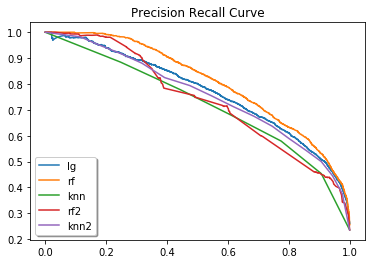

In [48]:
plt.title("Precision Recall Curve")
for i in range(len(model)):
    plt.plot( re1[i], pr[i], label=model_name[i] )
plt.legend(loc='lower left', shadow=True, fontsize='medium')
plt.show()

In [49]:
# площадь под кривой
for i in range(len(model)):
    print(model_name[i]," ",average_precision_score( Y_test, predictions[i][:, 1] ))

lg   0.7692381173063932
rf   0.80745308449703
knn   0.6619280570731823
rf2   0.7177267337277405
knn2   0.7363263802826836


In [50]:
# получаем значения false и true positive rate для различных значений порога
fpr = []
tpr = []
thres = []
for i in range(len(model)):
    fpri, tpri, thresi = roc_curve( Y_test, predictions[i][:, 1] )
    fpr.append(fpri)
    tpr.append(tpri)
    thres.append(thresi)

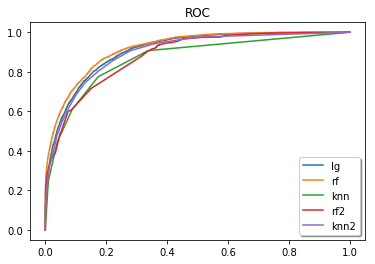

In [51]:
plt.title("ROC")
for i in range(len(model)):
    plt.plot( fpr[i], tpr[i], label=model_name[i] )
plt.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

In [52]:
for i in range(len(model)):
    print(model_name[i]," ",roc_auc_score( Y_test, predictions[i][:, 1] ))

lg   0.9080586805904962
rf   0.9192206491549293
knn   0.8657299306923639
rf2   0.8823139528109426
knn2   0.897716918020105


In [53]:
for i in range(len(model)):
    print(model_name[i]," ",auc( fpr[i], tpr[i] ))

lg   0.9080586805904962
rf   0.9192206491549293
knn   0.8657299306923639
rf2   0.8823139528109426
knn2   0.897716918020105
